# AI Final Project (Data Notebook)

Yutai Li, Coco Yu\
Data source: https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge
`
This project is aimed at classifying images into seven categories: anger, disgust, fear, happiness, sadness, surprise and neutral. The original data contain 35,887 instances including three columns: emotions (target), pixels (feature) and usage. The usage column is useless for our purpose (we plan to use sklearn package to split training and testing sets) and was therefore dropped. 3,369 duplicate values were found and taken out of the dataset. Number of instances for each target category can be found in the following codes. As there are some error images (e.g., image removed), we did some exploratory in the data and set a threshold of 230 for average pixels to remove these error images. For the purpose of our project, we only need gray scale images. As the original dataset is already on gray scale, we thereby did not manipulate the pixels.
`

## Data Cleaning

In [4]:
import os
import math
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

In [5]:
# os.getcwd()

In [6]:
# os.chdir('/Users/liyutai/Desktop/AI in social science/FER')

In [7]:
face_df = pd.read_csv('icml_face_data.csv')
face_df.columns = ["emotion", "usage", "pixels"]
face_df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [8]:
face_df

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [9]:
#find duplicates
duplicates = face_df[face_df.duplicated(subset = 'pixels', keep=False)]
duplicates

,emotion,usage,pixels
30,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...
38,0,Training,255 82 0 3 0 0 0 0 0 0 3 0 16 17 3 60 29 0 1 2...
50,2,Training,99 95 101 114 124 129 128 127 128 124 123 125 ...
62,3,Training,210 161 140 166 159 98 96 141 157 137 110 107 ...
69,5,Training,43 43 43 40 45 63 93 140 144 153 159 167 168 1...
...,...,...,...
35826,2,PrivateTest,200 201 199 197 198 199 199 198 197 196 194 19...
35833,5,PrivateTest,254 254 254 254 254 253 252 254 113 36 62 69 6...
35874,5,PrivateTest,43 43 51 73 94 97 102 95 99 107 126 144 154 17...
35875,5,PrivateTest,248 251 239 144 102 95 82 77 91 138 153 145 14...


In [10]:
duplicates[duplicates['pixels'] == duplicates.iloc[0,2]]

,emotion,usage,pixels
30,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...
19215,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...


In [11]:
len(duplicates)

3369

In [12]:
face_df = face_df.drop_duplicates(subset="pixels", keep='first')

In [13]:
face_df

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35881,0,PrivateTest,181 177 176 156 178 144 136 132 122 107 131 16...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [14]:
face_df.iloc[:,1].value_counts()

Training       27473
PublicTest      3293
PrivateTest     3268
Name: usage, dtype: int64

In [15]:
face_df['emotion'].value_counts()

3    8796
6    6052
4    5922
2    4820
0    4727
5    3257
1     460
Name: emotion, dtype: int64

In [16]:
# take out the usage column
face_df = face_df[['emotion', 'pixels']]
face_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [17]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

172


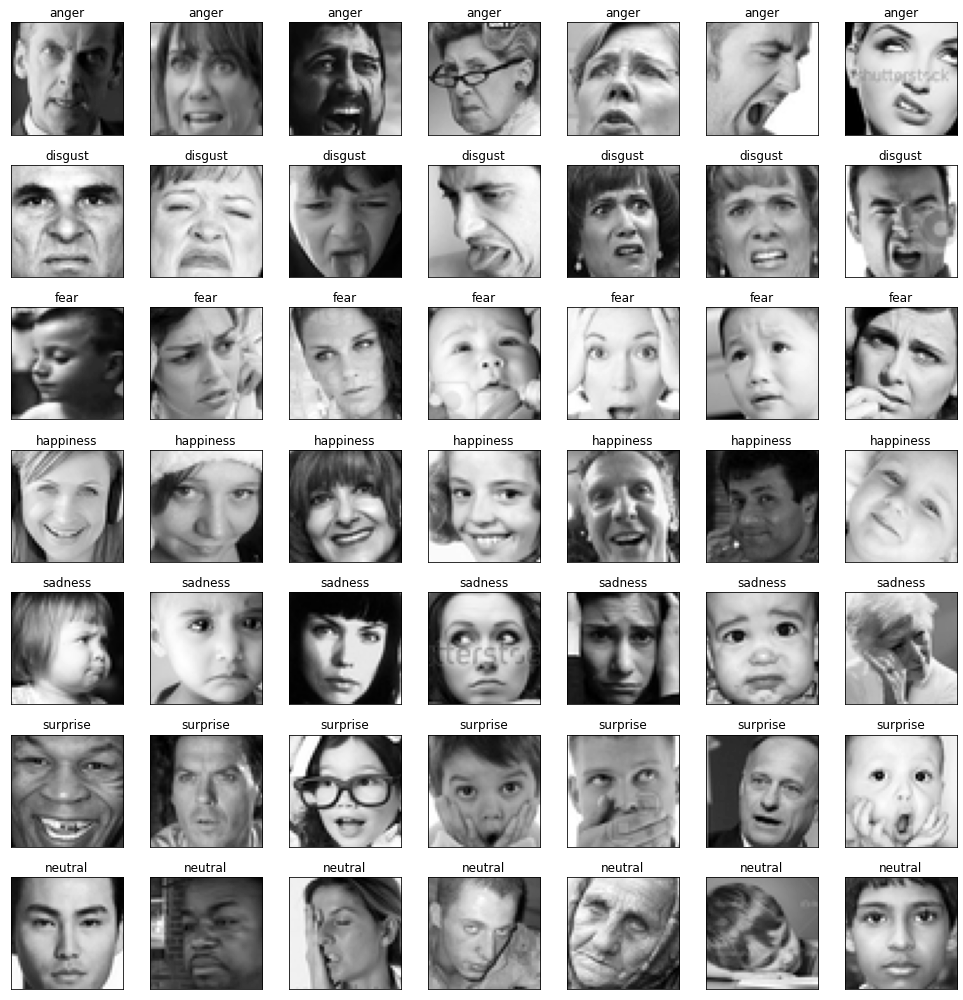

In [18]:
fig = pyplot.figure(1, (14, 14))

random.seed(0)
n = random.randint(0, high=460)
# n = 194
k = 0
print(n)

for label in sorted(face_df.emotion.unique()):
    for j in range(7):
        px = face_df[face_df.emotion==label].pixels.iloc[n]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        n += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

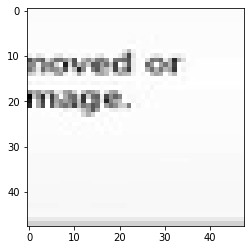

In [19]:
# error images
error_img = face_df[face_df.emotion==5].pixels.iloc[229]
error_img = np.array(error_img.split(' ')).reshape(48, 48).astype('float32')
ax = pyplot.subplot()
ax.imshow(error_img, cmap='gray')

In [20]:
error_img

array([[252., 252., 252., ..., 252., 252., 252.],
       [252., 252., 252., ..., 252., 252., 252.],
       [252., 252., 252., ..., 252., 252., 252.],
       ...,
       [251., 251., 251., ..., 251., 251., 251.],
       [241., 241., 241., ..., 241., 241., 241.],
       [225., 225., 225., ..., 225., 225., 225.]], dtype=float32)

In [21]:
np.average(error_img)

245.42578

In [22]:
random_pic = face_df['pixels'][0]
random_pic = np.array(random_pic.split(' ')).reshape(48, 48).astype('float32')
np.average(random_pic)

117.59288

In [23]:
copy = face_df
for i in range(len(copy)):
    copy['pixels'].iloc[i] = np.array(copy['pixels'].iloc[i].split(' ')).reshape(48, 48).astype('float32')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
def find_average(pixels):
    return np.average(pixels)

copy["mean"] = copy["pixels"].apply(find_average)

In [25]:
copy.head()

,emotion,pixels,mean
0,0,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",117.592880
1,0,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",126.971352
2,2,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",160.814240
3,4,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",130.503479
4,6,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",97.900177


In [26]:
## set threshold to 230
error_set = copy[copy['mean'] >= 230]
error_set.reset_index(drop=True, inplace = True)
error_set

,emotion,pixels,mean
0,5,"[[252.0, 252.0, 252.0, 252.0, 252.0, 252.0, 25...",245.425781
1,5,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",248.087234
2,5,"[[253.0, 253.0, 253.0, 253.0, 253.0, 253.0, 25...",242.844620
3,2,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",242.663635
4,3,"[[255.0, 254.0, 254.0, 254.0, 253.0, 254.0, 25...",244.990891
5,2,"[[252.0, 252.0, 252.0, 252.0, 252.0, 252.0, 25...",235.333328
6,0,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",244.865021
7,5,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",238.618484
8,3,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",243.335938
9,3,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",241.969177


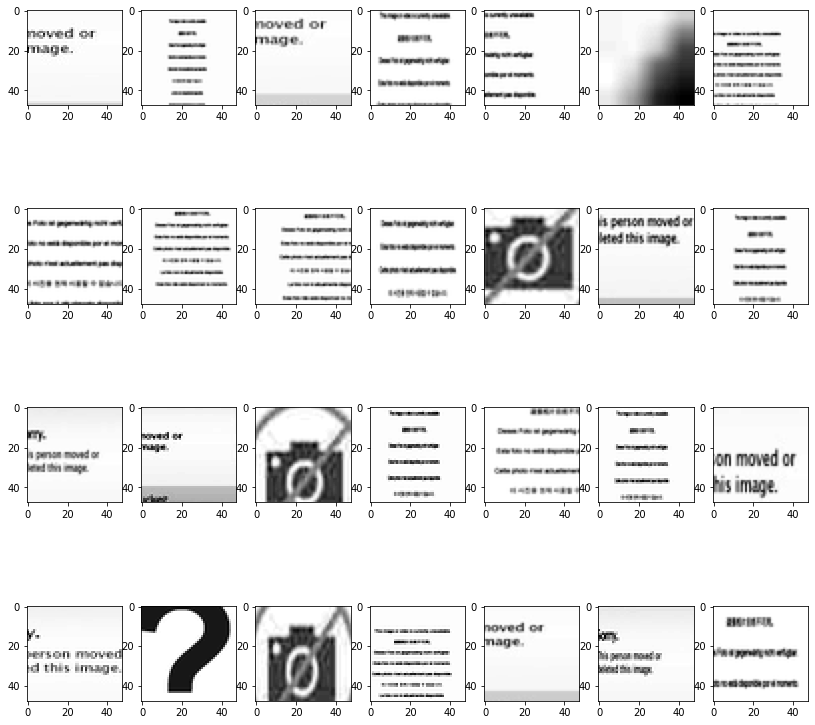

In [27]:
fig = pyplot.figure(1, (14, 14))
k = 1
for i in range(len(error_set)): 
    ax = pyplot.subplot(4,7,k)
    ax.imshow(error_set.iloc[i,1], cmap='gray')
    k += 1

In [28]:
## set threshold to 220
error_set220 = copy[(copy['mean'] >= 220) & (copy['mean'] < 230)]
error_set220.reset_index(drop=True, inplace = True)
error_set220

,emotion,pixels,mean
0,5,"[[255.0, 249.0, 246.0, 247.0, 248.0, 249.0, 24...",221.253906
1,0,"[[245.0, 221.0, 251.0, 254.0, 253.0, 255.0, 18...",223.685760
2,3,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",220.050354
3,2,"[[206.0, 203.0, 203.0, 206.0, 236.0, 255.0, 25...",226.347656
4,5,"[[255.0, 255.0, 255.0, 252.0, 255.0, 183.0, 15...",223.851135
5,3,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",224.223953
6,5,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",222.271698
7,4,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",224.969620
8,5,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",228.647568
9,5,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",229.396698


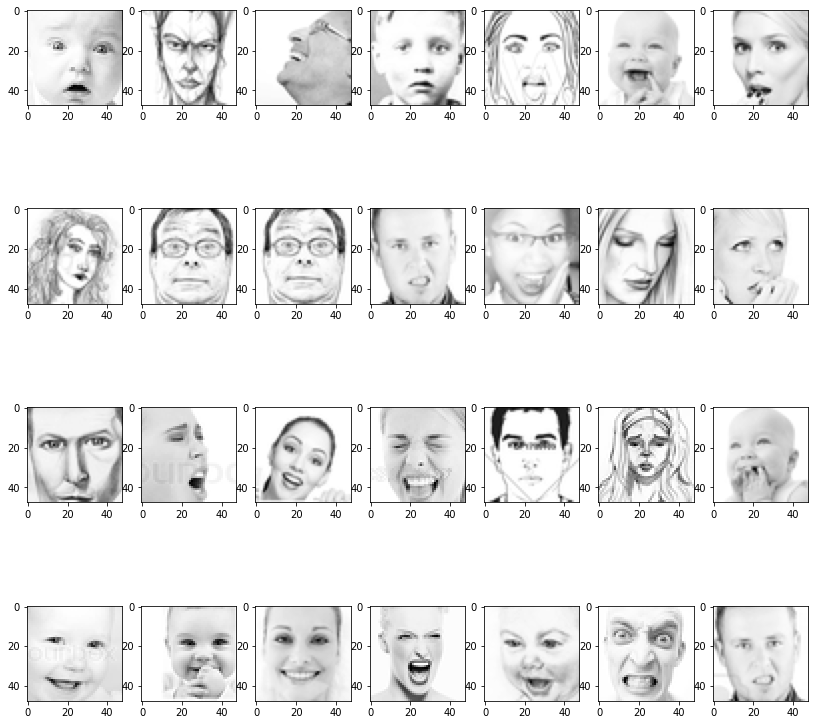

In [29]:
fig = pyplot.figure(1, (14, 14))
k = 1
for i in range(len(error_set220)): 
    ax = pyplot.subplot(4,7,k)
    ax.imshow(error_set220.iloc[i,1], cmap='gray')
    k += 1

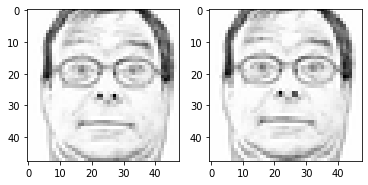

In [30]:
for i in range(2): 
    ax = pyplot.subplot(1,2,i+1)
    ax.imshow(error_set220.iloc[8+i,1], cmap='gray')

In [31]:
np.array_equal(error_set220.iloc[8,1], error_set220.iloc[9,1])

False

In [32]:
valid_face_df = copy[copy['mean'] <= 230]
valid_face_df.reset_index(drop=True, inplace = True)
valid_face_df

,emotion,pixels,mean
0,0,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",117.592880
1,0,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",126.971352
2,2,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",160.814240
3,4,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",130.503479
4,6,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",97.900177
...,...,...,...
34001,0,"[[181.0, 177.0, 176.0, 156.0, 178.0, 144.0, 13...",164.295135
34002,6,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...",63.258682
34003,3,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...",171.759979
34004,0,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...",161.609802


In [33]:
valid_face_df['pixels'].dtypes

dtype('O')

### Convolutional Neural Network (Running on Google Colab)

In [34]:
# import scikitplot
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [35]:
np.array(valid_face_df['pixels'][0:2].values.tolist()).reshape(2,48,48,1).shape

(2, 48, 48, 1)

In [36]:
image_array = np.array(valid_face_df['pixels'].values.tolist()).reshape(len(valid_face_df), 48, 48, 1)
image_array = np.stack(image_array, axis=0)
image_array.shape

(34006, 48, 48, 1)

In [37]:
image_array

array([[[[ 70.],
         [ 80.],
         [ 82.],
         ...,
         [ 52.],
         [ 43.],
         [ 41.]],

        [[ 65.],
         [ 61.],
         [ 58.],
         ...,
         [ 56.],
         [ 52.],
         [ 44.]],

        [[ 50.],
         [ 43.],
         [ 54.],
         ...,
         [ 49.],
         [ 56.],
         [ 47.]],

        ...,

        [[ 91.],
         [ 65.],
         [ 42.],
         ...,
         [ 72.],
         [ 56.],
         [ 43.]],

        [[ 77.],
         [ 82.],
         [ 79.],
         ...,
         [105.],
         [ 70.],
         [ 46.]],

        [[ 77.],
         [ 72.],
         [ 84.],
         ...,
         [106.],
         [109.],
         [ 82.]]],


       [[[151.],
         [150.],
         [147.],
         ...,
         [129.],
         [140.],
         [120.]],

        [[151.],
         [149.],
         [149.],
         ...,
         [122.],
         [141.],
         [137.]],

        [[151.],
         [151.],
      

In [38]:
le = LabelEncoder()
image_labels = le.fit_transform(valid_face_df.emotion)
image_labels = np_utils.to_categorical(image_labels)
image_labels.shape

(34006, 7)

In [39]:
image_labels[0:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [40]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(image_array, image_labels,
                                                    shuffle=True, stratify=image_labels,
                                                    test_size=0.3, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((23804, 48, 48, 1), (10202, 48, 48, 1), (23804, 7), (10202, 7))

In [42]:
image_width = X_train.shape[1]
image_height = X_train.shape[2]
image_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [43]:
# Normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [44]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(image_width, image_height, image_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [45]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [48]:
#the whole process took too long. We're considering parallel processing on Midway.
batch_size = 32
epochs = 10 ##will try larger
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/10
743/743 [==============================] - 1808s 2s/step - loss: 2.0986 - accuracy: 0.2315 - val_loss: 1.6726 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 2/10
743/743 [==============================] - 1819s 2s/step - loss: 1.7304 - accuracy: 0.3052 - val_loss: 1.5362 - val_accuracy: 0.4026 - lr: 0.0010
Epoch 3/10
743/743 [==============================] - 1805s 2s/step - loss: 1.6113 - accuracy: 0.3644 - val_loss: 1.4118 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 4/10
743/743 [==============================] - 1805s 2s/step - loss: 1.4941 - accuracy: 0.4208 - val_loss: 1.3539 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 5/10
743/743 [==============================] - 1809s 2s/step - loss: 1.4210 - accuracy: 0.4537 - val_loss: 1.2907 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 6/10
743/743 [==============================] - 1804s 2s/step - loss: 1.3650 - accuracy: 0.4748 - val_loss: 1.2259 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 7/10
743/743 [==============================] - 1809

In [49]:
model.evaluate(X_valid, y_valid)

319/319 [==============================] - 187s 583ms/step - loss: 1.1621 - accuracy: 0.5553


[1.1620550155639648, 0.55528324842453]

In [50]:
## testing data on Kaggle without ground truth labels
test_data = pd.read_csv("test.csv")
test_data

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...
7173,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
7174,178 174 172 173 181 188 191 194 196 199 200 20...
7175,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
7176,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [51]:
def clean_pixels(pixels):
  return np.array(pixels.split(' ')).reshape(48, 48).astype('float32')

test_data["cleaned"] = test_data["pixels"].apply(clean_pixels)
test_data

,pixels,cleaned
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,"[[254.0, 254.0, 254.0, 254.0, 254.0, 249.0, 25..."
1,156 184 198 202 204 207 210 212 213 214 215 21...,"[[156.0, 184.0, 198.0, 202.0, 204.0, 207.0, 21..."
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,"[[69.0, 118.0, 61.0, 60.0, 96.0, 121.0, 103.0,..."
3,205 203 236 157 83 158 120 116 94 86 155 180 2...,"[[205.0, 203.0, 236.0, 157.0, 83.0, 158.0, 120..."
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,"[[87.0, 79.0, 74.0, 66.0, 74.0, 96.0, 77.0, 80..."
...,...,...
7173,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39..."
7174,178 174 172 173 181 188 191 194 196 199 200 20...,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19..."
7175,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17..."
7176,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,"[[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68..."


In [70]:
X_Test = np.array(test_data['cleaned'].values.tolist()).reshape(len(test_data), 48, 48, 1)
test_out = model.predict(X_Test)
test_predict = (test_out > 0.5).astype(int)
## Having trouble inverse coding the labels, will try to fit and transform again

In [92]:
len(test_predict)

7178

In [ ]:
fig = pyplot.figure(1, (14, 14))

random.seed(0)
n = random.randint(0, high=460)
# n = 194
k = 0
print(n)

for label in sorted(face_df.emotion.unique()):
    for j in range(7):
        px = face_df[face_df.emotion==label].pixels.iloc[n]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        n += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()